# Dogs & Cats

You should download data from [HERE](https://www.dropbox.com/s/lrcq8x8qp7cd4si/train.zip?dl=0)

Then put .zip archive in "data" folder

Based on [this](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) blogpost

In this tutorial, we will present a few simple yet effective methods that you can use to build a powerful image classifier.

We will go over the following options:

* Training a small network from scratch (as a baseline)
* Using the bottleneck features of a pre-trained network

This will lead us to cover the following Keras features:

* fit_generator for training Keras a model using Python data generators
* layer freezing and model fine-tuning

...and more.

# Imports

In [1]:
import os
import zipfile
import shutil
import glob

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, Activation
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)

matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["legend.fontsize"] = 14

matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["font.size"] = 14

matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 20

Fix seed for reproducibility

In [3]:
np.random.seed(42)

# Data

## Structure preparation

Unzipping and folder structure preparation

In [4]:
shutil.rmtree("data/train", ignore_errors=True)
shutil.rmtree("data/valid", ignore_errors=True)

In [5]:
zip_ref = zipfile.ZipFile("data/train.zip", "r")
zip_ref.extractall("data/raw")
zip_ref.close()

In [6]:
os.mkdir("data/raw/valid")

os.mkdir("data/train")
os.mkdir("data/train/dog")
os.mkdir("data/train/cat")
os.mkdir("data/valid")
os.mkdir("data/valid/dog")
os.mkdir("data/valid/cat")

In [7]:
def move(filelist, in_path, out_path):
    for f in filelist:
        try:
            os.rename(os.path.join(in_path, f), os.path.join(out_path, f))
        except:
            pass

In [8]:
files = np.array(os.listdir("data/raw/train"))

In [9]:
idxs = np.arange(len(files))

In [10]:
train_idxs, valid_idxs = train_test_split(idxs, test_size=0.2, random_state=42)

In [11]:
move(files[valid_idxs], "data/raw/train/", "data/raw/valid/")

In [12]:
sample = ["train", "valid"]
clas = ["dog", "cat"]

In [13]:
for s in sample:
    for c in clas:
        files_to_move = glob.glob(os.path.join("data/raw/", s, c + "*.jpg"))
        files_to_move = map(lambda p: os.path.basename(p), files_to_move)
        move(files_to_move, os.path.join("data/raw/", s), os.path.join("data/", s, c))

In [14]:
shutil.rmtree("data/raw", ignore_errors=True)

In [15]:
path_train = "data/train"
path_valid = "data/valid"

In [16]:
if "cat.4110.jpg" in os.listdir("./data/valid/cat/"):
    os.rename("./data/valid/cat/cat.4110.jpg", "./data/train/cat/cat.4110.jpg")

## Image example

In [17]:
im_cat = plt.imread(os.path.join("./data/train/cat/", os.listdir("data/train/cat")[0]))
im_dog = plt.imread(os.path.join("./data/valid/dog/", os.listdir("data/valid/dog")[0]))

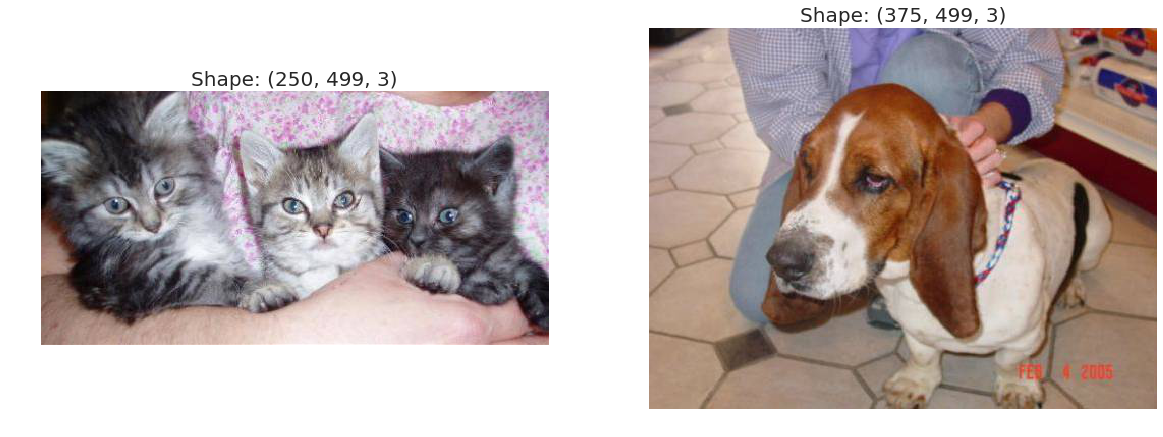

In [18]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(im_cat)
plt.axis("off")
plt.title("Shape: " + str(im_cat.shape))
plt.subplot(122)
plt.imshow(im_dog)
plt.axis("off")
plt.title("Shape: " + str(im_dog.shape))
plt.show()

In [19]:
img_shape = (224, 224, 3)

## QUIZ 1

What is the class of the following image

In [20]:
quiz_filename1 = "data/quiz1.jpg"

In [21]:
quiz_filename2 = "data/train/cat/cat.4110.jpg"

# Models

## Naive

The right tool for an image classification job is a convnet, so let"s try to train one on our data, as an initial baseline.

**NOTE**: It takes a while (even on GPU) with the whole set of data. For the sake of Quiz you can skip this part and proceed to the VGG

### Building

In [22]:
model_naive = Sequential()
model_naive.add(Convolution2D(32, (3, 3), input_shape=img_shape))
model_naive.add(Activation("relu"))
model_naive.add(MaxPooling2D(pool_size=(2, 2)))

model_naive.add(Convolution2D(32, (3, 3)))
model_naive.add(Activation("relu"))
model_naive.add(MaxPooling2D(pool_size=(2, 2)))

model_naive.add(Convolution2D(64, (3, 3)))
model_naive.add(Activation("relu"))
model_naive.add(MaxPooling2D(pool_size=(2, 2)))

model_naive.add(Flatten())
model_naive.add(Dense(64))
model_naive.add(Activation("relu"))
model_naive.add(Dropout(0.5))
model_naive.add(Dense(1))
model_naive.add(Activation("sigmoid"))

model_naive.compile(loss="binary_crossentropy",
                    optimizer="rmsprop",
                    metrics=["accuracy"])

Create *ImageDataGenerator* which is the class for streaming data from directory and pre-processing it

In [23]:
datagen = ImageDataGenerator(rescale=1./255)

In [24]:
gen_train = datagen.flow_from_directory(path_train,
                                        target_size=img_shape[:2],
                                        batch_size=64,
                                        class_mode="binary")

gen_valid = datagen.flow_from_directory(path_valid,
                                        target_size=img_shape[:2],
                                        batch_size=64,
                                        class_mode="binary")

Found 20001 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


### Training

Checkpoints to save best model

In [25]:
cb_loss = ModelCheckpoint(filepath="models/naive_loss.h5", 
                          monitor="val_loss", 
                          save_best_only=True, 
                          save_weights_only=True)
cb_acc = ModelCheckpoint(filepath="models/naive_acc.h5", 
                         monitor="val_acc", 
                         save_best_only=True, 
                         save_weights_only=True)

Fitting

In [26]:
%%time
hist_naive = model_naive.fit_generator(gen_train,
                                       steps_per_epoch=np.ceil(gen_train.n * 1. / gen_train.batch_size).astype(int), 
                                       validation_data=gen_valid,
                                       validation_steps=np.ceil(gen_valid.n * 1. / gen_valid.batch_size).astype(int), 
                                       callbacks=[cb_loss, cb_acc], 
                                       epochs=5, 
                                       workers=6)

Epoch 1/5
313/313 [==============================] - 38s - loss: 0.6503 - acc: 0.6462 - val_loss: 0.5526 - val_acc: 0.7183
Epoch 2/5
313/313 [==============================] - 37s - loss: 0.5214 - acc: 0.7446 - val_loss: 0.4852 - val_acc: 0.7738
Epoch 3/5
313/313 [==============================] - 38s - loss: 0.4613 - acc: 0.7860 - val_loss: 0.4726 - val_acc: 0.7754
Epoch 4/5
313/313 [==============================] - 38s - loss: 0.4164 - acc: 0.8133 - val_loss: 0.4437 - val_acc: 0.8042
Epoch 5/5
313/313 [==============================] - 38s - loss: 0.3823 - acc: 0.8298 - val_loss: 0.4481 - val_acc: 0.7962
CPU times: user 8min 22s, sys: 1min 36s, total: 9min 58s
Wall time: 3min 11s


Loss evolution

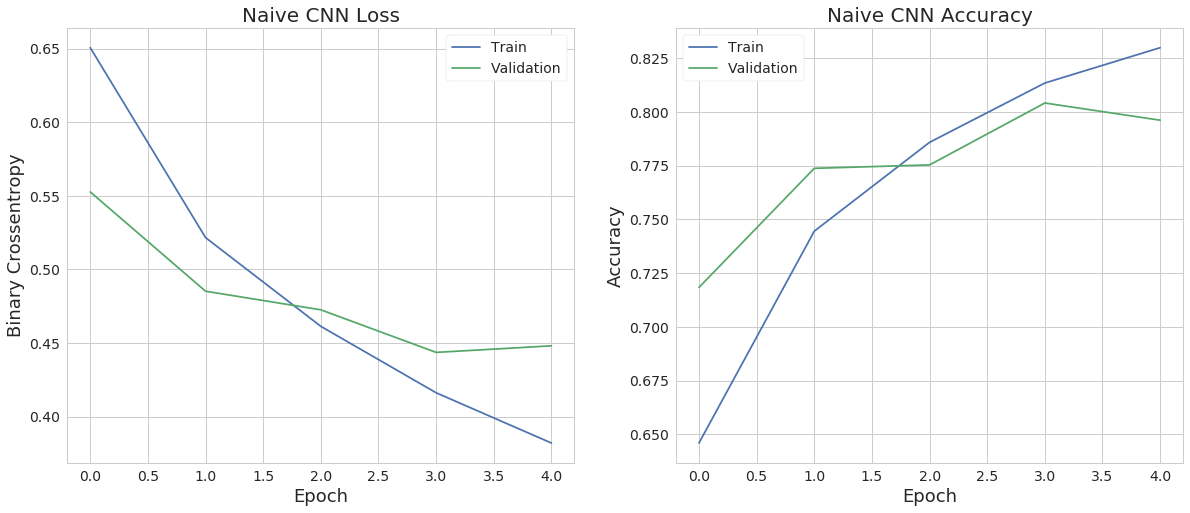

In [27]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(hist_naive.history["loss"], label="Train")
plt.plot(hist_naive.history["val_loss"], label="Validation")
plt.title("Naive CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()

plt.subplot(122)
plt.plot(hist_naive.history["acc"], label="Train")
plt.plot(hist_naive.history["val_acc"], label="Validation")
plt.title("Naive CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();

### Evaluation

In [28]:
_, acc_train = model_naive.evaluate_generator(generator=gen_train, 
                                              steps=np.ceil(gen_train.n * 1. / gen_train.batch_size).astype(int), 
                                              workers=6)
_, acc_valid = model_naive.evaluate_generator(generator=gen_valid, 
                                              steps=np.ceil(gen_valid.n * 1. / gen_valid.batch_size).astype(int), 
                                              workers=6)

In [29]:
print("Train accuracy: {0:.1f}".format(acc_train * 100))
print("Validation accuracy: {0:.1f}".format(acc_valid * 100))

Train accuracy: 86.4
Validation accuracy: 79.7


## VGG

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem.

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

### Extracting features

In [30]:
model_vgg = VGG16(include_top=False)

In [31]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [32]:
gen_train = datagen.flow_from_directory(path_train,
                                        target_size=img_shape[:2],
                                        batch_size=32,
                                        class_mode=None,
                                        shuffle=False)

gen_valid = datagen.flow_from_directory(path_valid,
                                        target_size=img_shape[:2],
                                        batch_size=32,
                                        class_mode=None,
                                        shuffle=False)

Found 20001 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


In [33]:
%%time
X_train = model_vgg.predict_generator(gen_train, 
                                      steps=np.ceil(gen_train.n * 1. / gen_train.batch_size).astype(int), 
                                      workers=6, 
                                      verbose=1)

626/626 [==============================] - 124s   
CPU times: user 2min 18s, sys: 1min 33s, total: 3min 52s
Wall time: 2min 5s


In [34]:
%%time
X_valid = model_vgg.predict_generator(gen_valid, 
                                      steps=np.ceil(gen_valid.n * 1. / gen_valid.batch_size).astype(int), 
                                      workers=6, 
                                      verbose=1)

157/157 [==============================] - 31s    
CPU times: user 35.8 s, sys: 23.8 s, total: 59.6 s
Wall time: 31.6 s


In [35]:
y_train = gen_train.classes
y_valid = gen_valid.classes

### Building top layers

In [55]:
model_top = Sequential()
model_top.add(Flatten(input_shape=X_train.shape[1:]))
model_top.add(Dense(256, activation="relu"))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation="sigmoid"))

model_top.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

### Training top layers

In [56]:
cb_loss = ModelCheckpoint(filepath="models/vgg_top_loss.h5", 
                          monitor="val_loss", 
                          save_best_only=True, 
                          save_weights_only=True)
cb_acc = ModelCheckpoint(filepath="models/vgg_top_acc.h5", 
                         monitor="val_acc", 
                         save_best_only=True, 
                         save_weights_only=True)

In [57]:
hist_top = model_top.fit(X_train, y_train,
                         validation_data=(X_valid, y_valid), 
                         epochs=10, batch_size=32, callbacks=[cb_loss, cb_acc])

Train on 20001 samples, validate on 4999 samples
Epoch 1/10
20001/20001 [==============================] - 7s - loss: 0.7715 - acc: 0.8279 - val_loss: 0.2716 - val_acc: 0.8794
Epoch 2/10
20001/20001 [==============================] - 6s - loss: 0.2600 - acc: 0.8988 - val_loss: 0.2000 - val_acc: 0.9248
Epoch 3/10
20001/20001 [==============================] - 5s - loss: 0.2335 - acc: 0.9122 - val_loss: 0.2137 - val_acc: 0.9266
Epoch 4/10
20001/20001 [==============================] - 5s - loss: 0.2158 - acc: 0.9222 - val_loss: 0.2077 - val_acc: 0.9248
Epoch 5/10
20001/20001 [==============================] - 5s - loss: 0.2007 - acc: 0.9271 - val_loss: 0.1982 - val_acc: 0.9350
Epoch 6/10
20001/20001 [==============================] - 6s - loss: 0.1913 - acc: 0.9316 - val_loss: 0.2146 - val_acc: 0.9236
Epoch 7/10
20001/20001 [==============================] - 5s - loss: 0.1829 - acc: 0.9364 - val_loss: 0.2091 - val_acc: 0.9298
Epoch 8/10
20001/20001 [==============================] - 6s -

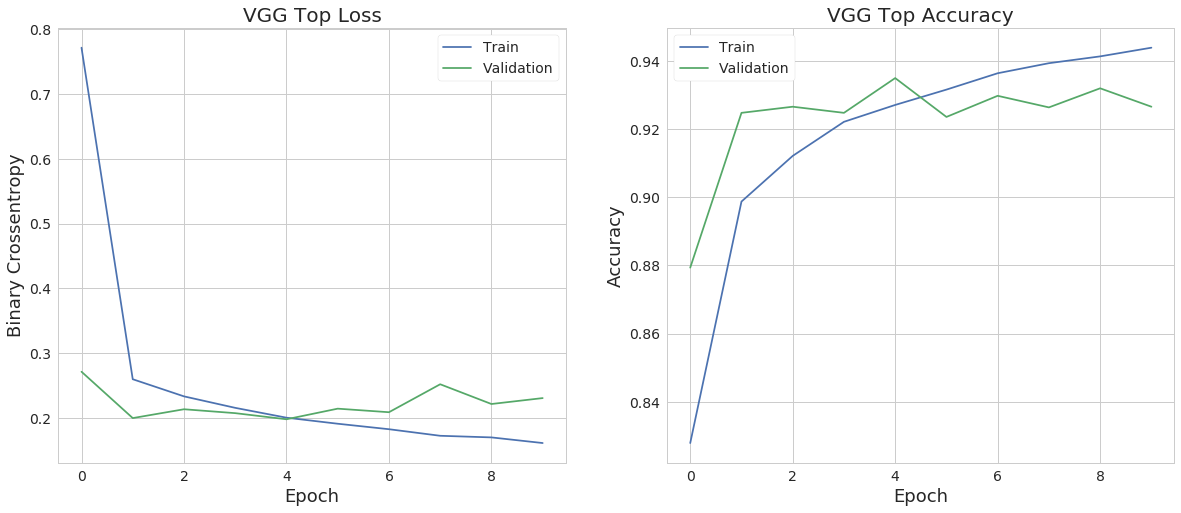

In [58]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(hist_top.history["loss"], label="Train")
plt.plot(hist_top.history["val_loss"], label="Validation")
plt.title("VGG Top Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()

plt.subplot(122)
plt.plot(hist_top.history["acc"], label="Train")
plt.plot(hist_top.history["val_acc"], label="Validation")
plt.title("VGG Top Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();

### Evaluating

In [59]:
preds_train = model_top.predict_classes(X_train).flatten()
preds_valid = model_top.predict_classes(X_valid).flatten()

4864/4999 [============================>.] - ETA: 0s

In [60]:
print("Train accuracy: {0:.1f}%".format(accuracy_score(y_train, preds_train) * 100))
print("Validation accuracy: {0:.1f}%".format(accuracy_score(y_valid, preds_valid) * 100))

Train accuracy: 96.3%
Validation accuracy: 92.7%


In [61]:
cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_valid = confusion_matrix(y_valid, preds_valid).astype(np.float32)
cm_valid /= cm_valid.sum(axis=1)[:, np.newaxis]

In [62]:
class_labels = ["Cat", "Dog"]

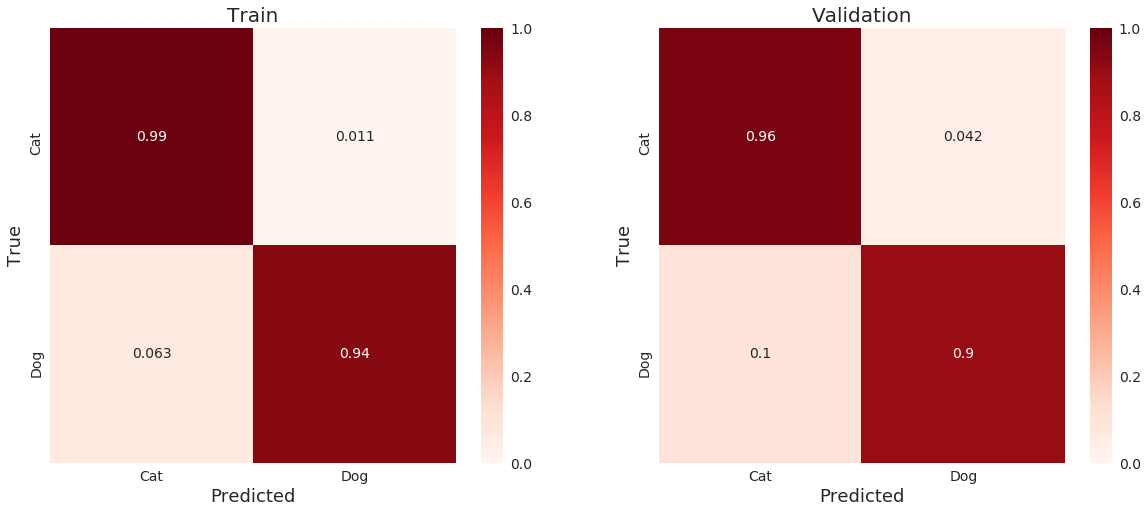

In [63]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, annot_kws={"fontsize": 14}, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train")

plt.subplot(122)
g = sns.heatmap(cm_valid, vmin=0, vmax=1, annot=True, annot_kws={"fontsize": 14}, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Validation")
plt.show()

### Prediction examples

In [64]:
preds_train_proba = model_top.predict(X_train).flatten()

In [65]:
preds_valid_proba = model_top.predict(X_valid).flatten()

In [66]:
filenames_valid = {"cat": os.listdir("data/valid/cat"), 
                   "dog": os.listdir("data/valid/dog")}

In [67]:
def plots_idx(idxs, classes, probas):
    rows = int(np.ceil(len(idxs) / 2.))
    plt.figure(figsize=(12, 6 * rows))
    for i in range(len(idxs)):
        plt.subplot(rows, 2, i + 1)
        im = plt.imread(os.path.join("data/valid", classes[i], filenames_valid[classes[i]][idxs[i]]))
        plt.imshow(im)
        if probas[i] > 0.5:
            label = "dog"
            proba = str(np.round(probas[i] * 100, 1))
        else:
            label = "cat"
            proba = str(np.round(100 - probas[i] * 100, 1))
        plt.title("I am " + proba + "% sure that it is " + label)
        plt.axis("off")
    plt.show()

In [68]:
num = 10

In [69]:
cats_idxs = np.random.choice(len(filenames_valid["cat"]), num // 2, replace=False)
dogs_idxs = np.random.choice(len(filenames_valid["dog"]), num // 2, replace=False)

In [70]:
idxs = np.concatenate((cats_idxs, dogs_idxs))
cl = np.array(["cat"] * int(num / 2) + ["dog"] * int(num / 2))
probas = np.concatenate((preds_valid_proba[cats_idxs], 
                         preds_valid_proba[dogs_idxs + len(filenames_valid["cat"])]))

In [71]:
perm = np.random.permutation(len(idxs))
idxs = idxs[perm]
cl = cl[perm]
probas = probas[perm]

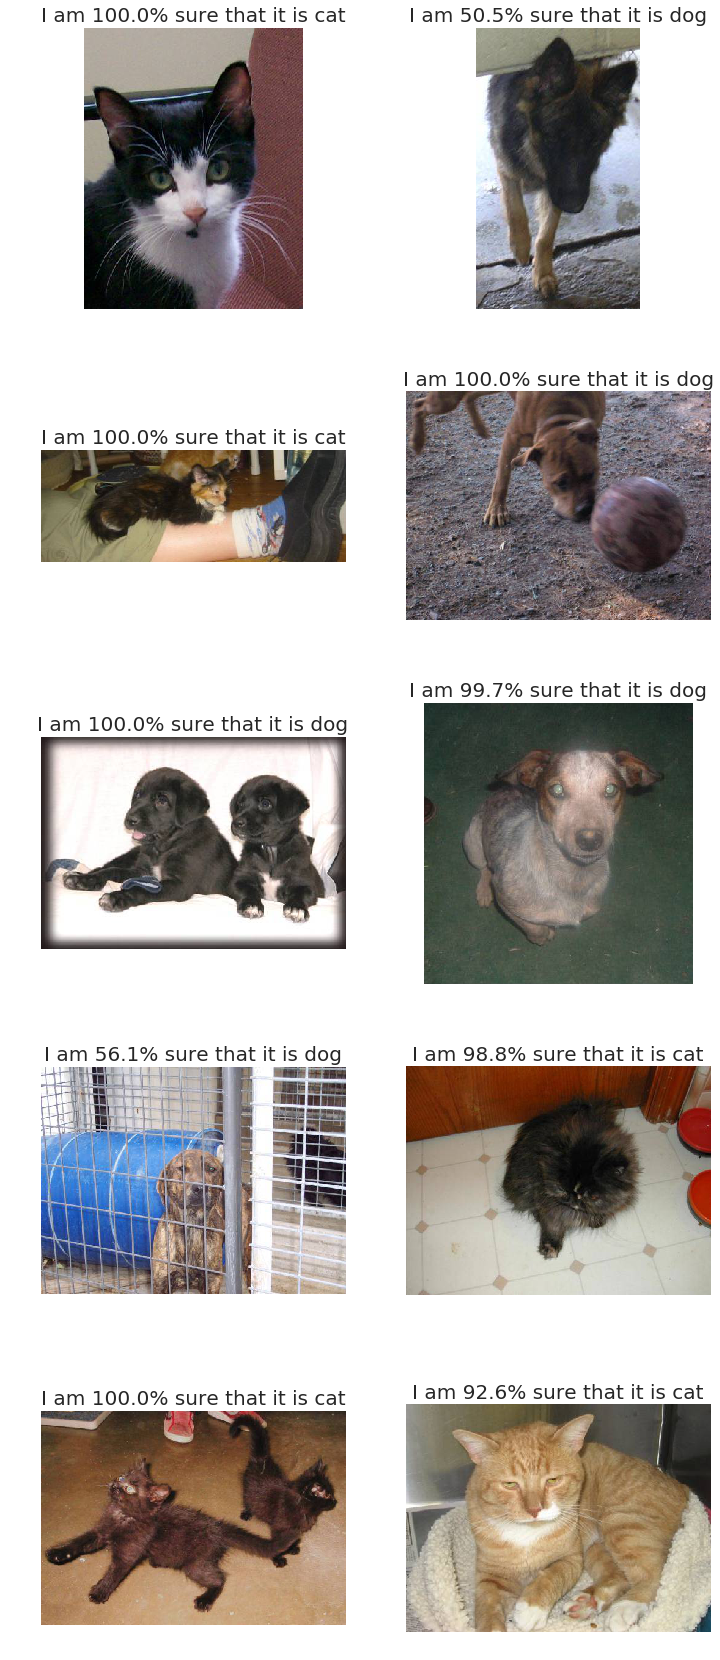

In [72]:
plots_idx(idxs, cl, probas)

## QUIZ 2

In [73]:
quiz_filename1 = "data/quiz1.jpg"

Am I a cat or a dog? What does the model say?

Check with your neighbor and see did you get the same class and score? Explain any differences

# Ideas to think on

For now you have $\approx 92\%$. Build on top of that to achieve state-of-the-art quality [[1](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition), [2](https://www.kaggle.com/c/dogs-vs-cats)].

Ideas to work on:
* **Finetune** not only top classification layer with VGG but also last **convolutional block**. For that take already pretrained VGG and top part, glue them, make trainable only these weigths that you need (last conv block and top part) and train them with low learning rate. This should give another $2-3\%$.
* **Data Augmentation**. $\text{ImageDataGenerator}$ class allows to transform initial pictures in number of ways (rotation, scaling etc.). Try it to improve quality.
* Use L1 or L2 **regularization**.